# **Product Review Sentiment Analysis** #

The goal of this project is to analyse customer reviews to determine their sentiment (positive, negative or neutral) based on the text content of the reviews and associated metadata. This will help understand customer feedback, identify product strengths and weaknesses and improve the overall customer experience by offering actionable insights.

**Problem Statement**: E-commerce platforms collect millions of product reviews from customers daily. However, manually analysing this vast amount of data to understand customer sentiment is inefficient. This project aims to automate sentiment analysis using machine learning and natural language processing techniques, identifying positive and negative sentiments in customer reviews to provide valuable insights for product improvement.

### **Key Steps in the Project** ###
- **Data Collection**: Utilise the provided dataset containing customer reviews and metadata.
- **Data Preprocessing**: Handle missing values, remove noise and standardise text in the 'review_body' and 'review_headline' columns.
- **Sentiment Labeling**: Use the 'star_rating' column to create sentiment labels (e.g., 1-2 stars as negative, 3 stars as neutral, 4-5 stars as positive).
- **Exploratory Data Analysis (EDA)**: Analyse sentiment distribution across different product categories and star ratings.
- **Feature Extraction and Text Processing**: Tokenise, remove stopwords and apply techniques using TF-IDF to transform text into numerical features.
- **Model Selection/Model Training**: Train a machine learning model (e.g., logistic regression, random forest or neural networks) to classify review sentiment.
- **Model Evaluation**: Evaluate the model using metrics such as accuracy, precision, recall and F1 score.
- **Visualisation**: Generate visual insights from the sentiment analysis, highlighting patterns in customer feedback.
- **Business Insights and Recommendations**: Offer actionable recommendations to improve product offerings and customer satisfaction based on sentiment trends.


### **Step 1: Importing Required Libraries** ###

In [385]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib
import warnings

# Optional: If you are performing text preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Optional: For creating word clouds if needed
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **Step 2: Data Collection** ###

In [366]:
# Load the dataset with the correct delimiter
file_path = r"C:\Users\USER\Downloads\Sentiment Analysis for Product Reviews\Amazon Product Review.txt"
data = pd.read_csv(file_path, delimiter=",", encoding="utf-8")

# Check the columns in the dataset
print(data.columns)

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'sentiment'],
      dtype='object')


### **Step 3 - Data Preprocessing** ###

In [367]:
# Ensure stopwords are downloaded
nltk.download('stopwords')

# Assuming 'data' is your DataFrame
# Drop rows with missing values in 'review_headline' or 'review_body'
data.dropna(subset=['review_headline', 'review_body'], inplace=True)

# Function to clean text data
def clean_text(text):
    # Remove HTML tags and special characters
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = text.lower()                   # Convert to lowercase
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

# Apply the clean_text function to 'review_headline' and 'review_body'
data['cleaned_review_headline'] = data['review_headline'].apply(clean_text)
data['cleaned_review_body'] = data['review_body'].apply(clean_text)

# Verify the new columns
print(data[['cleaned_review_headline', 'cleaned_review_body']].head())

# Clean extra spaces (if any) from the cleaned text
data['cleaned_review_headline'] = data['cleaned_review_headline'].str.replace(r'\s+', ' ', regex=True).str.strip()
data['cleaned_review_body'] = data['cleaned_review_body'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Check if the new columns were created successfully
print(data.columns)

# Combine all cleaned reviews into a single string for further analysis
if 'cleaned_review_body' in data.columns:
    all_reviews = ' '.join(data['cleaned_review_body'])
    print("Combined cleaned reviews ready for analysis.")
else:
    print("cleaned_review_body column not found. Please check the cleaning process.")

# Optionally, check the first few rows of the cleaned data
print(data[['cleaned_review_headline', 'cleaned_review_body']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                             cleaned_review_headline  \
0                                         five stars   
1  lots ads slow processing speed occasionally sh...   
2                                well thought device   
3  appsgames looking forward using compatible tab...   
4                                         five stars   

                                 cleaned_review_body  
0                                         great love  
1  lots adsslow processing speedoccasionally shut...  
2  excellent unit versatility tablet besides comp...  
3  bought amazon prime ended buying gb one camera...  
4         amazon products continue meet expectations  
Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'sentiment',
       'cleaned_review_headline', 'cleaned_review_body'

### **Step 4 - Sentiment Labelling** ###

In [368]:
# Function to label sentiment based on star rating
def label_sentiment(star_rating):
    if star_rating in [1, 2]:
        return 'negative'
    elif star_rating == 3:
        return 'neutral'
    elif star_rating in [4, 5]:
        return 'positive'

# Apply the function to create the sentiment_label column
data['sentiment_label'] = data['star_rating'].apply(label_sentiment)

# Verify the new column
print(data[['star_rating', 'sentiment_label']].head())

   star_rating sentiment_label
0            5        positive
1            3         neutral
2            5        positive
3            4        positive
4            5        positive


In [369]:
# Map sentiment labels to numeric values
data['sentiment'] = data['sentiment_label'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# Check the DataFrame to confirm changes
print(data[['star_rating', 'sentiment_label', 'sentiment']].head())

   star_rating sentiment_label  sentiment
0            5        positive          2
1            3         neutral          1
2            5        positive          2
3            4        positive          2
4            5        positive          2


### **Step 5 - Exploratory Data Analysis (EDA)** ###

<Figure size 1600x700 with 0 Axes>

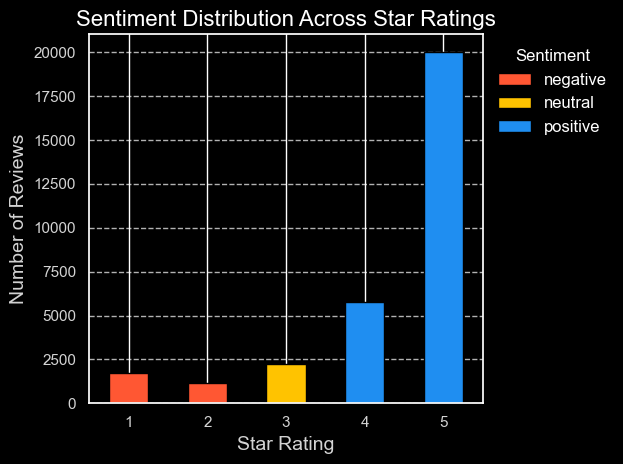

In [370]:
# 1. Sentiment Distribution Across Star Ratings
plt.style.use('dark_background')  # Set a style with a dark background

# Count the sentiment labels for each star rating
sentiment_counts_by_rating = data.groupby('star_rating')['sentiment_label'].value_counts().unstack().fillna(0)

# Plot the distribution of sentiment across star ratings
plt.figure(figsize=(16, 7))
sentiment_counts_by_rating.plot(kind='bar', stacked=True, color=['#FF5733', '#FFC300', '#1F8EF1'], edgecolor='black')
plt.title('Sentiment Distribution Across Star Ratings', fontsize=16, color='white')
plt.xlabel('Star Rating', fontsize=14, color='lightgray')
plt.ylabel('Number of Reviews', fontsize=14, color='lightgray')
plt.xticks(rotation=0, color='lightgray')
plt.yticks(color='lightgray')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Sentiment', fontsize=12, bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

<Figure size 1800x800 with 0 Axes>

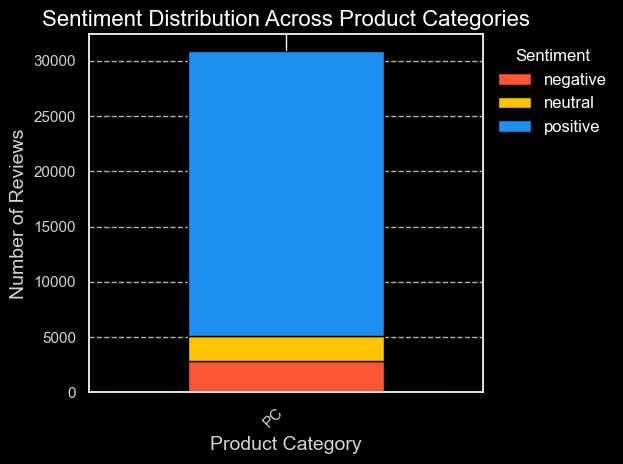

In [371]:
# 2. Sentiment Distribution Across Product Categories

plt.figure(figsize=(18, 8))  # Set figure size for product categories
sentiment_counts_by_category = data.groupby('product_category')['sentiment_label'].value_counts().unstack().fillna(0)

# Plot the distribution of sentiment across product categories
sentiment_counts_by_category.plot(kind='bar', stacked=True, color=['#FF5733', '#FFC300', '#1F8EF1'], edgecolor='black')
plt.title('Sentiment Distribution Across Product Categories', fontsize=16, color='white')
plt.xlabel('Product Category', fontsize=14, color='lightgray')
plt.ylabel('Number of Reviews', fontsize=14, color='lightgray')
plt.xticks(rotation=45, ha='right', color='lightgray')
plt.yticks(color='lightgray')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Sentiment', fontsize=12, bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

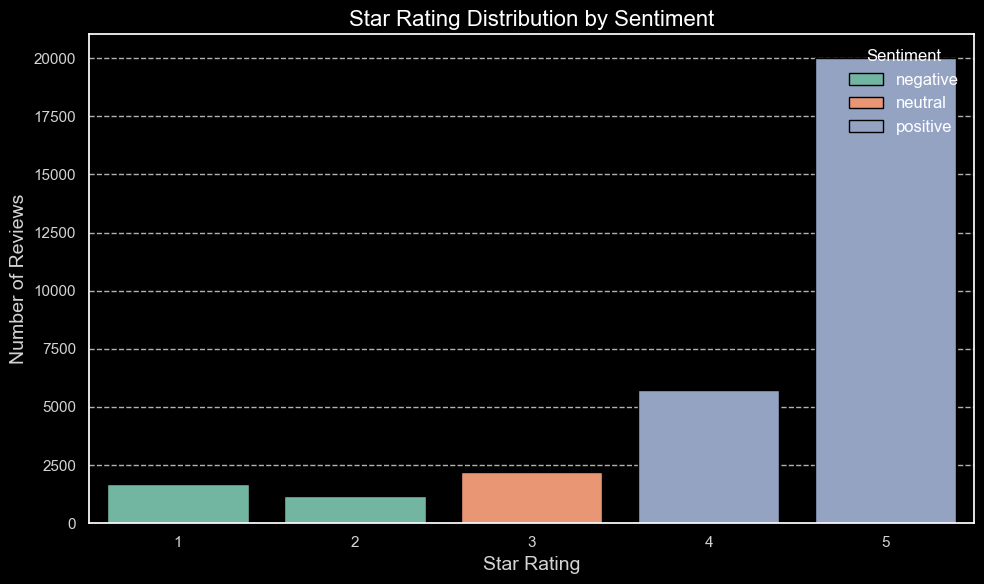

In [372]:
# 3. Star Rating Distribution by Sentiment
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='star_rating', hue='sentiment_label', palette='Set2', edgecolor='black')
plt.title('Star Rating Distribution by Sentiment', fontsize=16, color='white')
plt.xlabel('Star Rating', fontsize=14, color='lightgray')
plt.ylabel('Number of Reviews', fontsize=14, color='lightgray')
plt.xticks(rotation=0, color='lightgray')
plt.yticks(color='lightgray')
plt.legend(title='Sentiment', fontsize=12, loc='upper right', frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

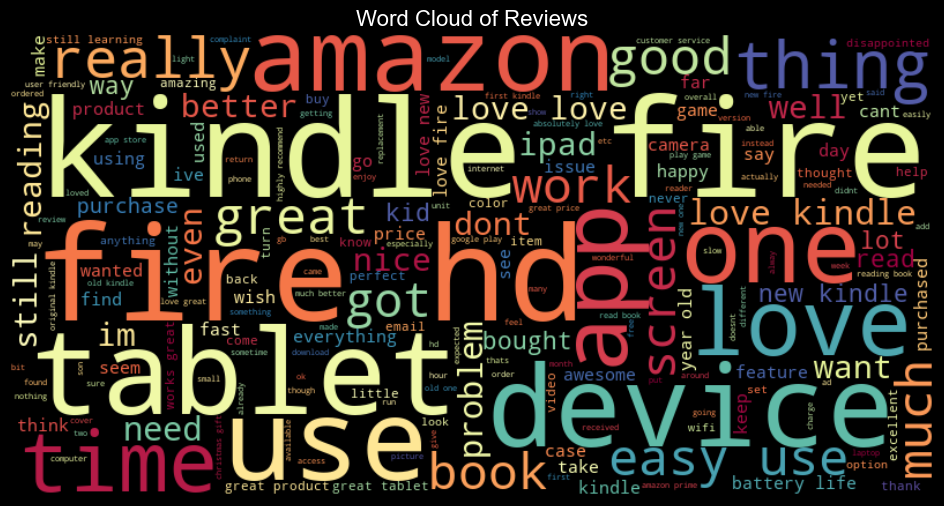

In [373]:
# 4. Perform Basic Text Analysis - Word Cloud

# Combine all cleaned reviews into a single string
all_reviews = ' '.join(data['cleaned_review_body'])

# Generate a word cloud with a unique color scheme
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Spectral',
    contour_color='white',
    contour_width=1,
    random_state=42  # Ensures reproducibility
).generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Reviews', fontsize=16, color='white')
plt.show()

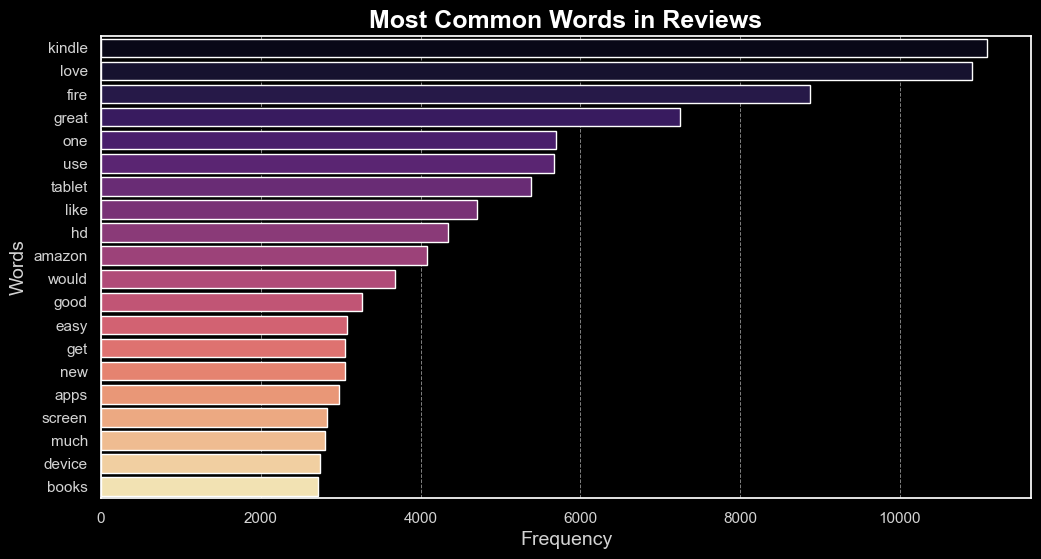

In [374]:
# 5. Most Common Words

# Tokenize the cleaned review body
all_words = ' '.join(data['cleaned_review_body']).split()

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the most common words (e.g., top 20)
most_common_words = word_counts.most_common(20)

# Create a DataFrame from the most common words
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Plot the most common words with a vibrant color palette and custom styling
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=common_words_df, hue='Word', palette='magma', errorbar=None, legend=False)
plt.title('Most Common Words in Reviews', fontsize=18, fontweight='bold', color='white')
plt.xlabel('Frequency', fontsize=14, color='lightgray')
plt.ylabel('Words', fontsize=14, color='lightgray')
plt.grid(axis='x', color='gray', linestyle='--', linewidth=0.7)
plt.xticks(color='lightgray')
plt.yticks(color='lightgray')
plt.gca().set_facecolor('black')  # Set the background color to black
plt.show()


### **Step 6: Feature Extraction and Text Processing** ###

In [375]:
# Assuming 'data' is your DataFrame with cleaned review body
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the cleaned review body
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_review_body'])

# Convert the TF-IDF matrix to a DataFrame for better visualization (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Check the shape of the TF-IDF matrix
print("TF-IDF matrix shape:", tfidf_matrix.shape)

# Display the first few rows of the TF-IDF DataFrame
print(tfidf_df.head())

TF-IDF matrix shape: (30840, 20364)
   ___   _g  _really_  aaa  aaaa  aaaaaaa  aabsolutely  aahing  aan  \
0  0.0  0.0       0.0  0.0   0.0      0.0          0.0     0.0  0.0   
1  0.0  0.0       0.0  0.0   0.0      0.0          0.0     0.0  0.0   
2  0.0  0.0       0.0  0.0   0.0      0.0          0.0     0.0  0.0   
3  0.0  0.0       0.0  0.0   0.0      0.0          0.0     0.0  0.0   
4  0.0  0.0       0.0  0.0   0.0      0.0          0.0     0.0  0.0   

   aanything  ...  zone  zones  zonethe  zoodles  zoom  zoomed  zooming  \
0        0.0  ...   0.0    0.0      0.0      0.0   0.0     0.0      0.0   
1        0.0  ...   0.0    0.0      0.0      0.0   0.0     0.0      0.0   
2        0.0  ...   0.0    0.0      0.0      0.0   0.0     0.0      0.0   
3        0.0  ...   0.0    0.0      0.0      0.0   0.0     0.0      0.0   
4        0.0  ...   0.0    0.0      0.0      0.0   0.0     0.0      0.0   

   zooms  zynga  òrdered  
0    0.0    0.0      0.0  
1    0.0    0.0      0.0  
2    

### **Step 7: Model Selection/Model Training** ###

In [376]:
# Check if the sentiment_label column exists
print(data.columns)

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'sentiment',
       'cleaned_review_headline', 'cleaned_review_body', 'sentiment_label'],
      dtype='object')


In [386]:
# Suppress warnings
warnings.filterwarnings("ignore")

# 1. Train-Test Split
X = tfidf_matrix  # Replace with your TF-IDF features variable
y = data['sentiment']  # This should be your sentiment labels (numeric)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# 2. Train the Logistic Regression Model
# Initialise the model
model = LogisticRegression(max_iter=5000)  # Increase max_iter if you get convergence warnings

# Train the model
model.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

### **Step 8: Model Evaluation** ###

In [387]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.8750
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.52      0.58       572
           1       0.42      0.13      0.20       443
           2       0.90      0.98      0.94      5153

    accuracy                           0.88      6168
   macro avg       0.66      0.54      0.58      6168
weighted avg       0.85      0.88      0.85      6168



In [388]:
# Hyperparameter Tuning using Grid Search
# Define the model
model = LogisticRegression(max_iter=1000)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

# Setup the GridSearchCV
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Best parameters: {'C': 1, 'solver': 'saga'}
Best cross-validation accuracy: 0.8759322017192288


In [389]:
# Cross-Validation
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.87700101 0.87558257 0.86522092 0.87798946 0.88386704]
Mean cross-validation score: 0.8759322017192288


In [390]:
# Error Analysis
# Create a DataFrame with true and predicted values
error_analysis = pd.DataFrame({'True Label': y_test, 'Predicted Label': y_pred})
misclassified = error_analysis[error_analysis['True Label'] != error_analysis['Predicted Label']]

# Display misclassified instances
print("Misclassified instances:")
print(misclassified.head())

Misclassified instances:
       True Label  Predicted Label
2513            0                2
18417           0                2
21929           1                0
25536           1                2
6119            2                1


In [391]:
# Model Interpretation
if hasattr(model, 'coef_'):
    # Get feature names from the vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Get the coefficients
    coefficients = model.coef_[0]

    # Create a DataFrame to display feature importance
    importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

    # Calculate absolute importance and sort
    importance_df['Importance'] = np.abs(importance_df['Coefficient'])
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Display feature importance
    print("Feature importance:")
    print(importance_df.head(10))  # Display top 10 features

    # Visualization of feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Features')
    plt.show()
else:
    print("Model has not been fitted correctly.")

Model has not been fitted correctly.


In [383]:
# Save the model
joblib.dump(model, 'sentiment_model.pkl')

['sentiment_model.pkl']

In [384]:
model = joblib.load(r"C:\Users\USER\Downloads\Sentiment Analysis for Product Reviews\sentiment_model.pkl")
tfidf_vectorizer = joblib.load(r"C:\Users\USER\Downloads\Sentiment Analysis for Product Reviews\vectorizer.pkl")